In [67]:
# Initialize Otter
import otter
grader = otter.Notebook("lab5.ipynb")

---

<h1><center>SDSE Lab 5 <br><br> Logistic regression, Performance metrics, and LASSO regularization </center></h1>

---

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="Precision is ill-defined and being set to 0.0")

import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,recall_score, accuracy_score
from sklearn.model_selection import cross_validate

rng_seed = 454

In this lab we will apply logistic regression to the problem of diagnosing breast cancer. We will use the scikit-learn package to build the model, and we will write functions to assess its performance. We will also perform feature selection using L1 (LASSO) regularization.

# Load the data

In [69]:
data = sklearn.datasets.load_breast_cancer()
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

# Put the data into a pandas DataFrame

In [70]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data['target']
N = len(df['target'])
del data
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Flip the target value

The scikit-learn dataset encodes a benign tumor as a 1 and a malignant tumor as a 0. This confuses the language, so let's flip it.

In [71]:
df['target'] = 1-df['target']
# df['target']

# Data exploration

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

The pandas dataframe provides the `corr()` methods, which computes the correlation matrix. Good predictor variables are characterized by having a large correlation with the output, but small correlation with other predictors. 

In [73]:
df.corr()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,-0.012838


Focus on the correlations with the target variable. Sort them from largest to smallest in absolute value. The ones at the top of the list are good candidates to include in our model, but they may not be. We will use Lasso regularization for feature selection.

In [74]:
df.corr()['target'].abs().sort_values(ascending=False)

target                     1.000000
worst concave points       0.793566
worst perimeter            0.782914
mean concave points        0.776614
worst radius               0.776454
mean perimeter             0.742636
worst area                 0.733825
mean radius                0.730029
mean area                  0.708984
mean concavity             0.696360
worst concavity            0.659610
mean compactness           0.596534
worst compactness          0.590998
radius error               0.567134
perimeter error            0.556141
area error                 0.548236
worst texture              0.456903
worst smoothness           0.421465
worst symmetry             0.416294
mean texture               0.415185
concave points error       0.408042
mean smoothness            0.358560
mean symmetry              0.330499
worst fractal dimension    0.323872
compactness error          0.292999
concavity error            0.253730
fractal dimension error    0.077972
smoothness error           0

# Training and testing data

The first step is to split the dataset into training and test sets. We will reserve 20% of the data for testing.  The code below uses scikit-learn's `train_test_spit` method to generate training and testing datasets. 

In [75]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:,:-1],
                                                df['target'], 
                                                test_size=0.2, 
                                                random_state=rng_seed )

len(Xtrain), len(Xtest)

(455, 114)

In [76]:
ytrain

519    0
161    1
507    0
140    0
23     1
      ..
294    0
506    0
98     0
28     1
218    1
Name: target, Length: 455, dtype: int64

# Train a logistic regression model

Our first model will be based on the most highly correlated feature only: `worst concave points`. 
The following code creates a logistic regression object. To compute the coefficients of the model, we pass the training data to the `fit` method.

In [77]:
Xtrain1 = Xtrain[['worst concave points']]

model = LogisticRegression()
model.fit(Xtrain1,ytrain) 

LogisticRegression()

# 1. Compute the confusion matrix

Our next step is to assess the performance of the simple logistic regression model by building its confusion matrix. The can be done easily with scikit-learn's `confusion_matrix()` function. However here we will build it by hand.

The `compute_confusion_matrix` takes as parameters the trained model, along with the training or testing data (`X` and `y`). 

It should return a dictionary with keys `{'TP', 'FP', 'TN', 'FN'}` corresponding to the true positives, false positives, true negatives, and false negatives obtained by predicting the response for `X` and comparing it to `y`.

In our case a 'positive' outcome is `y==1` (a malignant tumor).

In [78]:
def compute_confusion_matrix(model,X,y):
    cm = dict.fromkeys({'TP', 'FP', 'TN', 'FN'}, 0)
    yhat = model.predict(X)
    for i, j in zip(y, yhat):
        cm['TN'] += 1 if i == 0 and j == 0 else 0
        cm['FP'] += 1 if i == 0 and j == 1 else 0
        cm['TP'] += 1 if i == 1 and j == 1 else 0
        cm['FN'] += 1 if i == 1 and j == 0 else 0
    return cm

In [79]:
cm_train = compute_confusion_matrix(model,Xtrain1,ytrain)
cm_train

{'FP': 0, 'FN': 98, 'TP': 69, 'TN': 288}

In [80]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Compute accuracy

`compute_accuracy` takes a dictionary returned by `compute_confusion_matrix` and returns the scalar value of the accuracy, found with:

$$ \text{accuracy} = \frac{TP+TN}{TP+TN+FP+FN} $$

Use `compute_accuracy` to find the training and testing accuracy for the model.

In [81]:
def compute_accuracy(cm):
    accuracy = (cm['TP'] + cm['TN'])/(cm['TP'] + cm['TN'] + cm['FP'] + cm['FN'])
    return accuracy

In [82]:
acc_train = compute_accuracy(cm_train)
acc_train

0.7846153846153846

In [83]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Compute precision and recall

Repeat part 2 but for precision and recall. 

In [84]:
def compute_precision(cm):
    precision = cm['TP']/(cm['TP'] + cm['FP'])
    return precision

def compute_recall(cm):
    recall = cm['TP']/(cm['TP'] + cm['FN'])
    return recall

In [85]:
prn_train = compute_precision(cm_train)
rcl_train = compute_recall(cm_train)

prn_train, rcl_train

(1.0, 0.41317365269461076)

In [86]:
grader.check("q3")

q3 results: All test cases passed!

# 4. L1 regularized logistic regression

We now repeat the previous exercise, but instead of choosing the features by their correlation with the output, we will use the LASSO regularizer. 

## 4.1 Create a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

Here we will create a pipeline that first normalizes the data using a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), and then trains a logistic regression model on the scaled data. 

Scaling input features is not a theoretical necesity for logistic regression. However it can be helpful for a) improving the numerical search and b) making comparisons amongst the trained coefficients. 

Read the documentation (linked in the title) on Pipelines to see how they work. Each item in the pipeline must have a string identifier. Use the label **`scaler`** for your `StandardScaler` and **`logreg`** for your logistic regression model. 

Pass the following parameter values to the logistic regression constructor. What does each of these do?

``` python
C=1
penalty='l1'
solver='liblinear'
max_iter=1000
random_state=rng_seed
```

Fit the model using the pipeline's `fit` method and using the full training data.

In [87]:
# Remember to use the name `scaler` for your StandardScaler, and `logreg` for your logistic regression model.

model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000, random_state=rng_seed))])
model.fit(Xtrain, ytrain) 

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    random_state=454, solver='liblinear'))])

In [88]:
grader.check("q4p1")

q4p1 results: All test cases passed!

## 4.2 Cross validation

In the next part we will select features by sweeping over values of the regularization constant. We need a validation strategy for evaluating the performance of each level of regularization. We will use Use scikit-learn's `cross_validate` method for this. 

Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for an explanation of the input arguments. 

Then run `cross_validate` on the pipeline model we trained in the previous part. Use `cv=3` and record the accuracy, precision and recall by passing in `scoring=('accuracy','precision','recall')`.

Save the mean of the three test metrics as `acc_cv`, `prn_cv`, and `rcl_cv`.

In [89]:
scores = cross_validate(model, Xtrain, ytrain, cv=3, scoring=('accuracy','precision','recall'))
# print(scores.keys())
acc_cv = np.mean(scores['test_accuracy'])
prn_cv = np.mean(scores['test_precision'])
rcl_cv = np.mean(scores['test_recall'])

In [90]:
grader.check("q4p2")

q4p2 results: All test cases passed!

## 4.3 Sweep over the regularization weight

We will now use the regularization parameter $\lambda$ to shrink the coefficients. As we increase $\lambda$ we should see the coefficients for the less useful features shrink to zero. In scikit-learn, the regularization parameter is called `C`, and is passed into the constructor for `LogisticRegression`. `C` actually equals  $1/\lambda$, so increasing regularization strength (shrinking the parameters) corresponds to decreasing `C`.

In [91]:
numCs = 40

Cs = np.logspace(-3,2,numCs)
D = Xtrain.shape[1]

coefs = np.empty((numCs,D))

# Initialize the performance arrays to `np.empty(numCs)`.
acc_cv = np.empty(numCs)
prn_cv = np.empty(numCs)
rcl_cv = np.empty(numCs)

for c, C in enumerate(Cs):   

    # Create a fit a pipeline, as you did in the previous part.
    # Remember to use the name `scaler` for your StandardScaler, and `logreg` for your logistic regression model.
    model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(C=C, penalty='l1', solver='liblinear', max_iter=1000, random_state=rng_seed))])
    model.fit(Xtrain, ytrain) 
    
    # Extract the trained coefficients from the model and store them in the `coefs` array.
    coefs[c,:] = model.named_steps['logreg'].coef_[0,:]
    
    # Use the same code from the previous part to compute cross-validation scores
    scores = cross_validate(model, Xtrain, ytrain, cv=3, scoring=('accuracy','precision','recall'))
    acc_cv[c] = np.mean(scores['test_accuracy'])
    prn_cv[c] = np.mean(scores['test_precision'])
    rcl_cv[c] = np.mean(scores['test_recall'])


In [92]:
grader.check("q4p3")

q4p3 results: All test cases passed!

# Plots

The plot below should show that C=0.1 is amongst the lowest values that maximize the test performance metrics.

Text(0.5, 0, 'C')

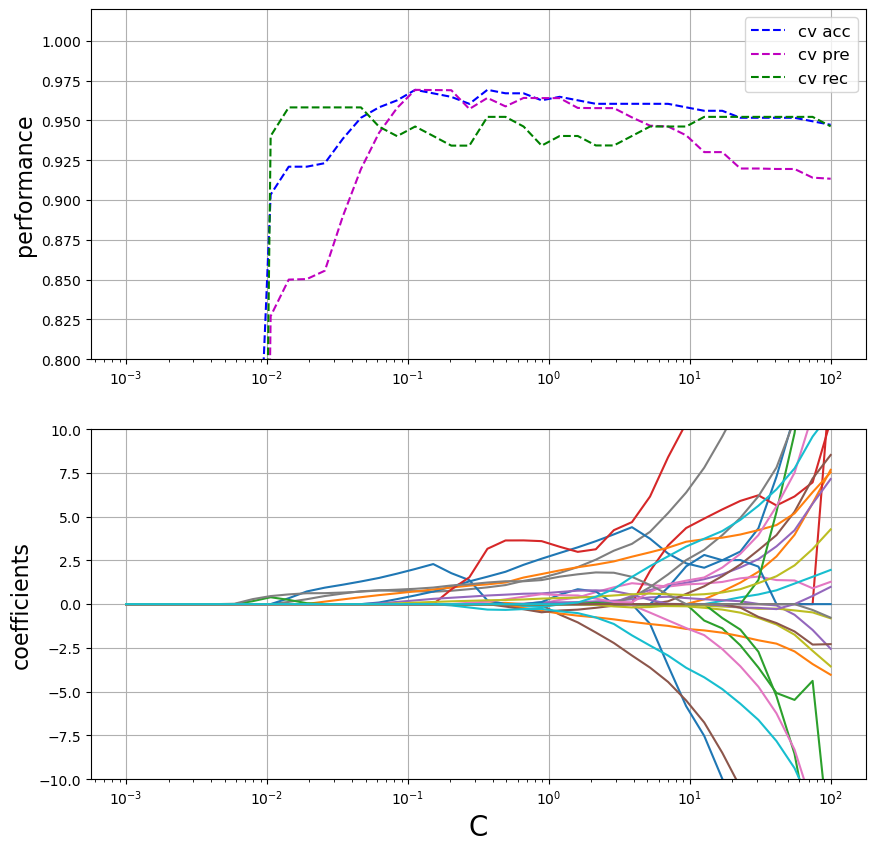

In [93]:
plt.subplots(figsize=(10,10),nrows=2)

plt.subplot(211)
plt.semilogx(Cs, acc_cv,'b--', label='cv acc')
plt.semilogx(Cs, prn_cv,'m--', label='cv pre')
plt.semilogx(Cs, rcl_cv,'g--', label='cv rec')
plt.legend(fontsize=12)
plt.ylim(0.8,1.02)
plt.grid()
plt.ylabel('performance',fontsize=16)

plt.subplot(212)
plt.semilogx(Cs, coefs)
plt.ylim(-10,10)
plt.grid()
plt.ylabel('coefficients',fontsize=16)

plt.xlabel('C',fontsize=20)

# Final model

The plot above shows that the best model occurs near C=0.1. We will take Cs[16]=0.11 to be the best value. Next, we sort and plot the absolute values of the coefficients for that model. Notice that only seven features have a non-zero coefficient.

<StemContainer object of 3 artists>

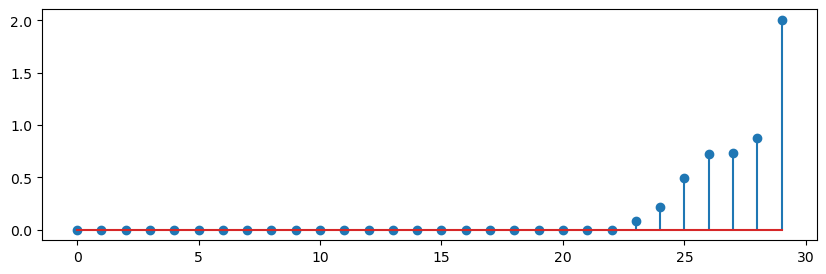

In [94]:
best_C_ind = 16
abs_coef = np.abs(coefs[best_C_ind,:])
sorted_coeff_ind = np.argsort(abs_coef)

plt.figure(figsize=(10,3))
plt.stem(abs_coef[sorted_coeff_ind])

Let's see which seven features were selected.

In [95]:
feature_names = np.array(df.columns[:-1])
best_features = feature_names[sorted_coeff_ind[-1:-8:-1]]
best_features

array(['worst radius', 'worst concave points', 'mean concave points',
       'worst texture', 'radius error', 'worst smoothness',
       'worst symmetry'], dtype=object)

Suppose that we can only keep 4 features, perhaps because we are constrained by the time and cost of performing medical examinations. In the next cell, store the top 4 featuers in the list `best_four_features`. Then use this list to construct training inputs `Xtrain2` with 4 columns. Then define and train the final logistic regression model. 

_Type your answer here, replacing this text._

In [96]:
# Remember to use the name `scaler` for your StandardScaler, and `logreg` for your logistic regression model.
best_four_features = best_features[:4]
Xtrain2 = Xtrain[best_four_features]
final_model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())])
final_model.fit(Xtrain2, ytrain)

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [97]:
Xtest2 = Xtest[best_four_features]

acc_test = accuracy_score(ytest,final_model.predict(Xtest2))
prn_test = precision_score(ytest,final_model.predict(Xtest2))
rcl_test = recall_score(ytest,final_model.predict(Xtest2))
acc_test, prn_test, rcl_test

(0.9824561403508771, 0.9777777777777777, 0.9777777777777777)

In [98]:
grader.check("q5")

q5 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [99]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4p1 results: All test cases passed!

    q4p2 results: All test cases passed!

    q4p3 results: All test cases passed!

    q5 results: All test cases passed!
